In [1]:
import mouseQPCRModelSelection 
import numpy as np
import time
import AssignGPGibbsSingleLoop
import GPflow
import numpy as np
import time
import cPickle as pickle
import assigngp_dense
from matplotlib import pyplot as plt
%matplotlib inline

In [11]:
Bpossible = np.linspace(2,70,3)
pt,Yall = mouseQPCRModelSelection.LoadMouseQPCRData(subsetSelection=1)
Y = Yall#[:,0][None].T
print 'Y'
print Y.shape
strExp = 'MouseQPCR_Exp1'
m,mV = mouseQPCRModelSelection.InitModels(pt,Y)

Loaded data data/guo_ssData.p with nrowsXncols = (437, 2).
(437, 2)
(437,)
LoadMouseQPCRData output
(437, 2)
(437,)
Y
(437, 2)
Branching kernel =====================
unnamed.branchkernelparam.\u001bBv\u001b transform:(none) prior:None [FIXED]
[[ 1.]]
unnamed.branchkernelparam.kern.\u001bvariance\u001b transform:+ve prior:None
[ 1.]
unnamed.branchkernelparam.kern.\u001blengthscales\u001b transform:+ve prior:None
[ 1.]
unnamed.white.\u001bvariance\u001b transform:+ve prior:None
[ 1.]
Initialise models: MAP =====================

model.kern.branchkernelparam.\u001bBv\u001b transform:(none) prior:None [FIXED]
[[ 1.]]
model.kern.branchkernelparam.kern.\u001bvariance\u001b transform:+ve prior:None
[ 1.]
model.kern.branchkernelparam.kern.\u001blengthscales\u001b transform:+ve prior:None
[ 1.]
model.kern.white.\u001bvariance\u001b transform:+ve prior:None
[ 1.]
model.likelihood.\u001bvariance\u001b transform:+ve prior:None
[ 1.]
Initialise models: VB =====================
compiling tensorflow 

In [12]:
Bpossible=None
strSaveState='test'
fSoftVBAssignment=False
fOptimizeHyperparameters = False
fReestimateMAPZ=False
numMAPsteps = 10
D=Y.shape[1]
print D

2


In [13]:
# Do the MAP solution and plot assignments
Kbranch = m.kern
pt = mV.t
b = 20

Bcrap = np.atleast_2d(b) # crappy branch point

# reinitialise hyperparameters
Kbranch.white.variance = 1e-6
Kbranch.branchkernelparam.kern.lengthscales = 100 # 20 + (90. - b) / 2. # 65
Kbranch.branchkernelparam.kern.variance = 2 #0.0012 #  2.3158
m.likelihood.variance = 0.08
mV.likelihood.variance = m.likelihood.variance._array

# should recompute Kernel everytime we update kernel hyperparameters
m.CompileAssignmentProbability(fDebug=False,fMAP=True) 

# set branching point
m.kern.branchkernelparam.Bv = Bcrap 

print '============> B=' + str(m.kern.branchkernelparam.Bv._array.flatten())

# Random assignment for given branch point

np.random.seed(47)

randomAssignment = AssignGPGibbsSingleLoop.GetRandomInit(pt,Bcrap,m.indices)
print 'MAP assignment.'
(chainState, bestAssignment,_,condProbs) = \
    m.InferenceGibbsMAP(fReturnAssignmentHistory=True,fDebug=False,\
    maximumNumberOfSteps=numMAPsteps,\
    startingAssignment=list(randomAssignment))
    
    
# Very important!    
mV.kern.branchkernelparam.Bv.fixed = False
mV._compile()


============> B=[ 20.]
MAP assignment.
Performing MAP inference with B=[ 20.]
Converged after 2 iterations, lik=-878.437
compiling tensorflow function...
done


In [14]:
m

Name,values,prior,constriant
model.kern.branchkernelparam.Bv,[[ 20.]],None,(none)
model.kern.branchkernelparam.kern.variance,[ 2.],None,+ve
model.kern.branchkernelparam.kern.lengthscales,[ 100.],None,+ve
model.kern.white.variance,[ 1.00000000e-06],None,+ve
model.likelihood.variance,[ 0.08],None,+ve


In [15]:
mV

Name,values,prior,constriant
model.kern.branchkernelparam.Bv,[[ 20.]],None,(none)
model.kern.branchkernelparam.kern.variance,[ 2.],None,+ve
model.kern.branchkernelparam.kern.lengthscales,[ 100.],None,+ve
model.kern.white.variance,[ 1.00000000e-06],None,+ve
model.logPhi,"[[-0.02929351 -1.15131319 0.31226025 ..., -0.08981396 0.05218156 1.33655341] [ 0.06425957 -1.22724411 0.48129965 ..., -0.4423405 -0.16998138 1.1412879 ] [ 0.04618751 0.34541421 -1.09714562 ..., -0.0892363 -0.22880348 0.66813155] ..., [-1.03802935 -0.88558207 -1.64207751 ..., 0.78628331 3.09352651 1.06096836] [ 0.36348864 -0.13130002 -0.91928563 ..., 1.58220264 -0.12656499 -2.11974707] [-0.06697769 -0.11734281 -1.25095786 ..., -1.92520656 0.62802938 -0.1343889 ]]",None,(none)
model.likelihood.variance,[ 0.08],None,+ve


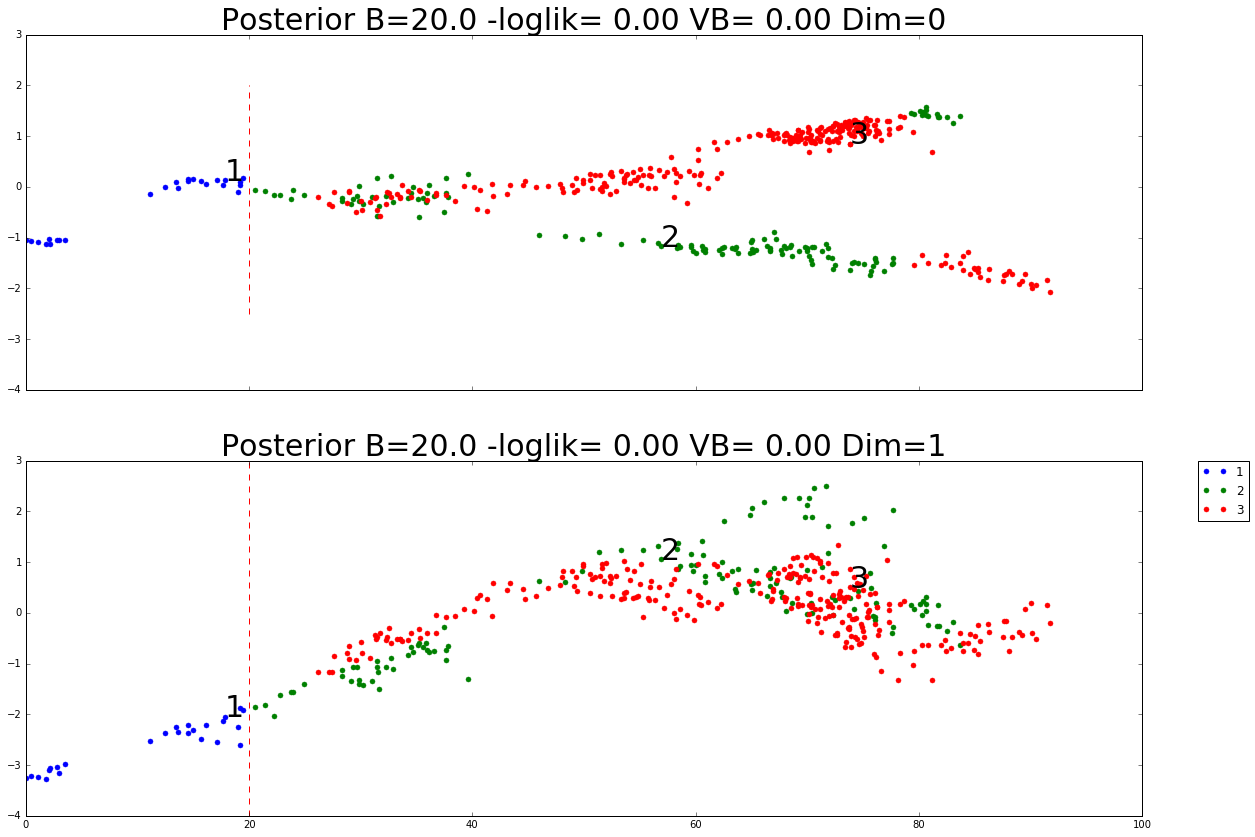

In [16]:
# Plot MAP solution
assigngp_dense.PlotSample(D,m.XExpanded[bestAssignment, : ],3,Y,Bcrap,lw=5.,fs=30, \
                      mV=None, figsizeIn=(D*10,D*7),title='Posterior B=%.1f -loglik= %.2f VB= %.2f'%(b,0,0))

Variational kernel branch value [ 22.]
InitialisePhi:Warning switching to square transform
B=22.0. VB bound=664.46.
Variational kernel branch value [ 25.57894737]
InitialisePhi:Warning switching to square transform
B=25.5789473684. VB bound=663.15.
Variational kernel branch value [ 29.15789474]
InitialisePhi:Warning switching to square transform
B=29.1578947368. VB bound=659.25.
Variational kernel branch value [ 32.73684211]
InitialisePhi:Warning switching to square transform
B=32.7368421053. VB bound=650.86.
Variational kernel branch value [ 36.31578947]
InitialisePhi:Warning switching to square transform
B=36.3157894737. VB bound=644.35.
Variational kernel branch value [ 39.89473684]
InitialisePhi:Warning switching to square transform
B=39.8947368421. VB bound=643.39.
Variational kernel branch value [ 43.47368421]
InitialisePhi:Warning switching to square transform
B=43.4736842105. VB bound=642.88.
Variational kernel branch value [ 47.05263158]
InitialisePhi:Warning switching to squa

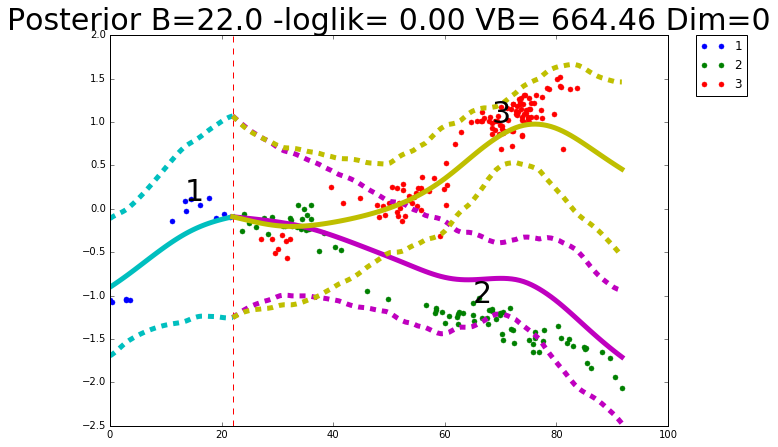

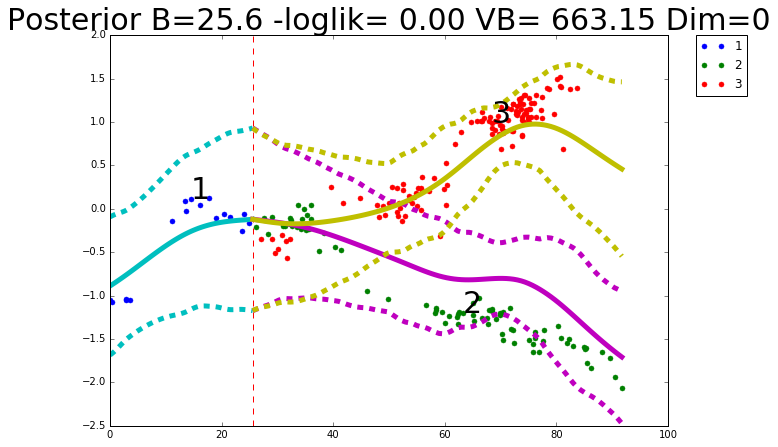

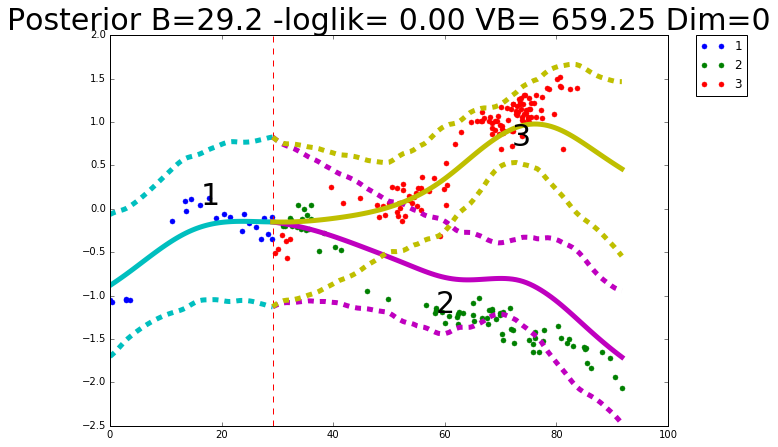

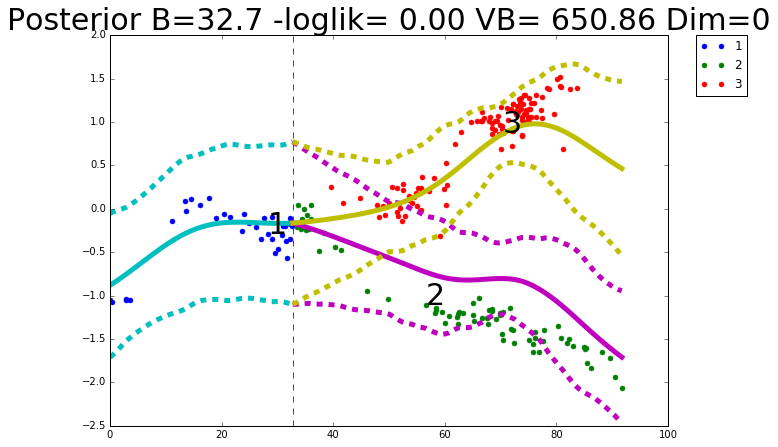

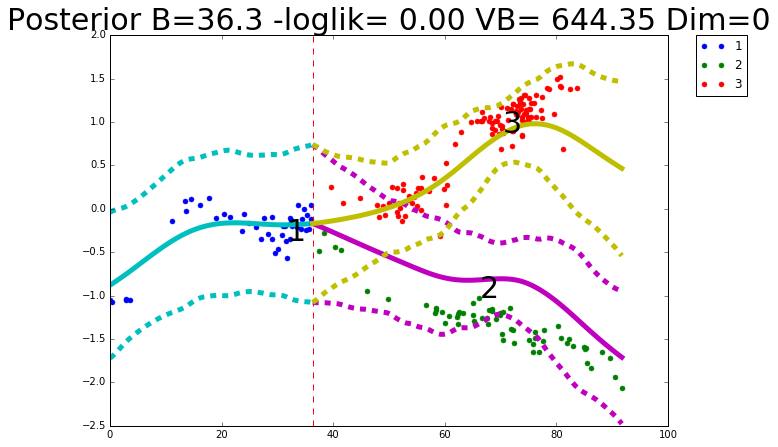

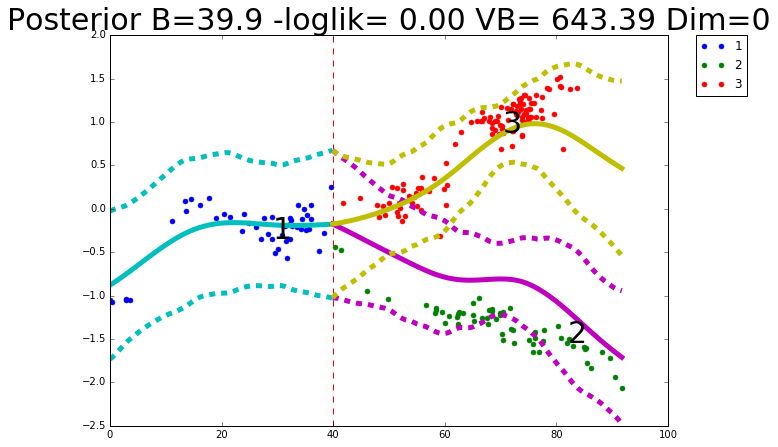

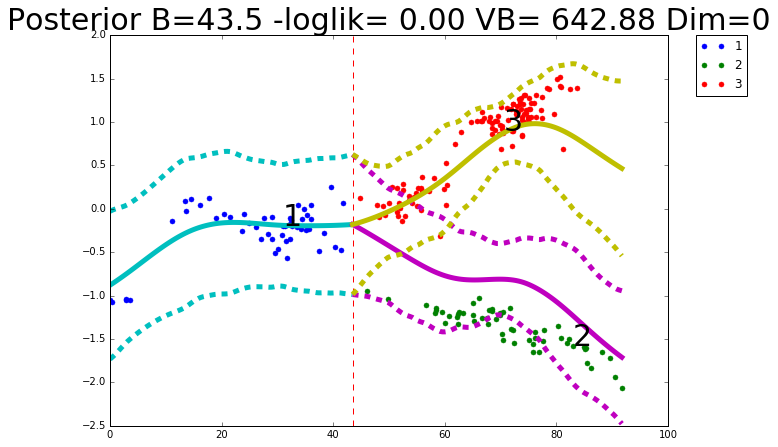

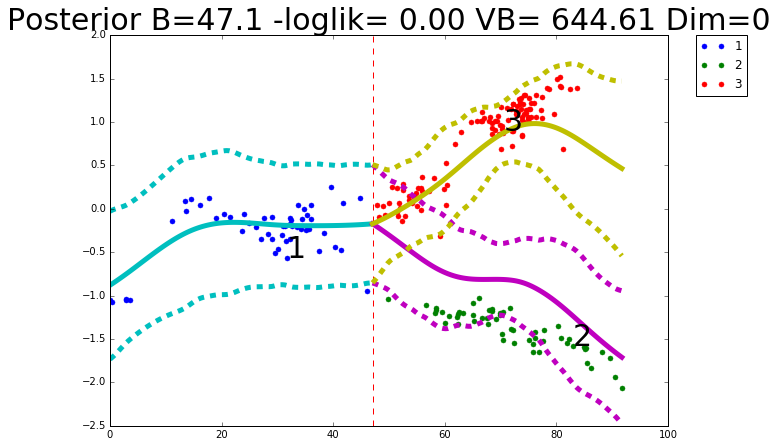

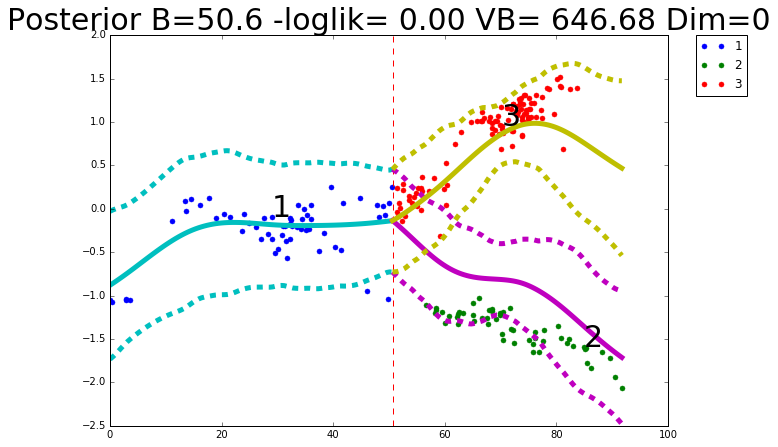

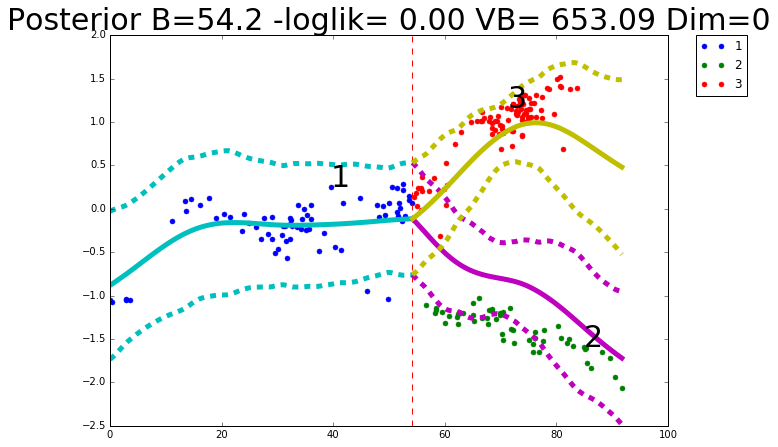

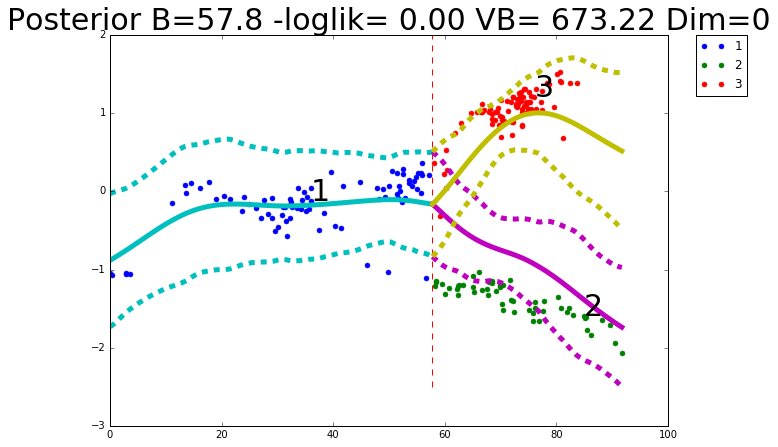

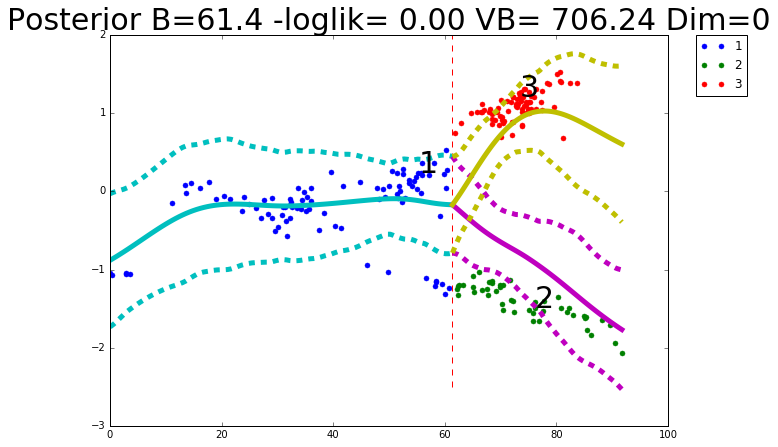

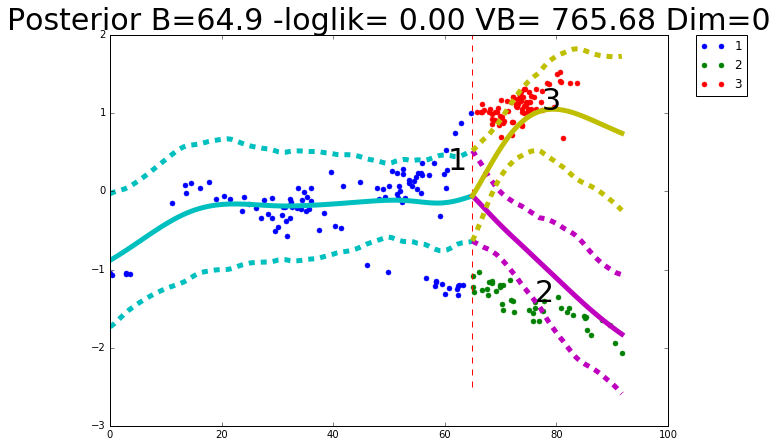

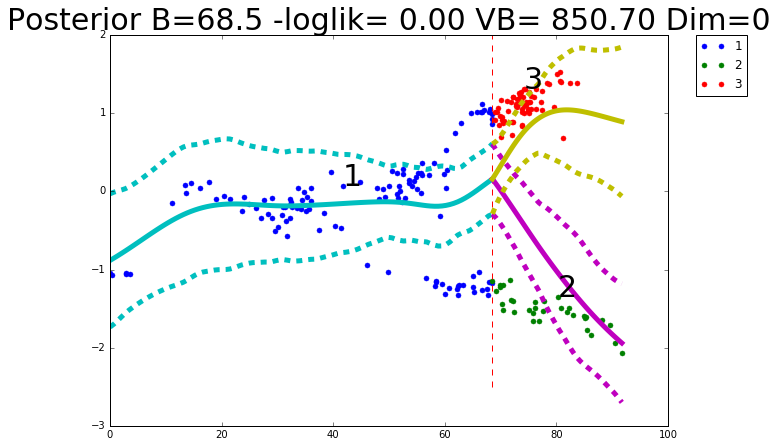

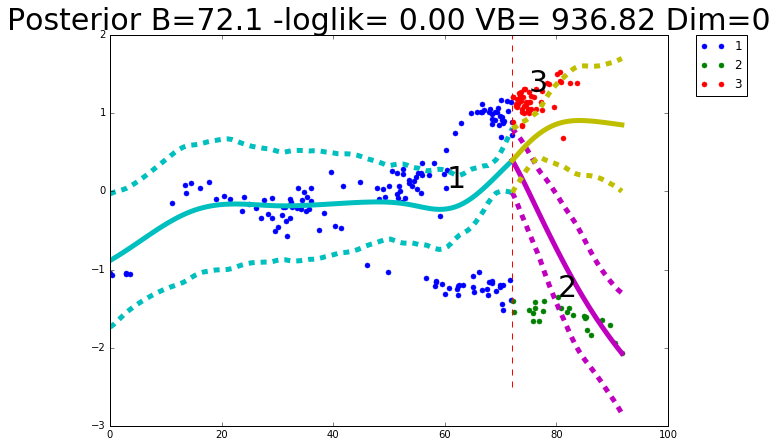

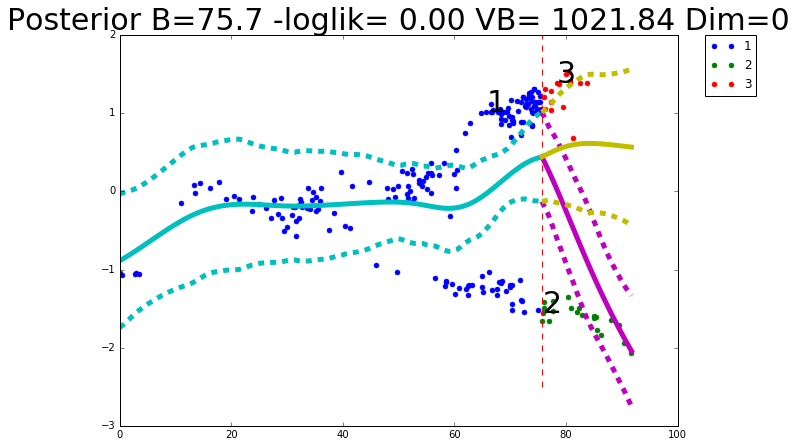

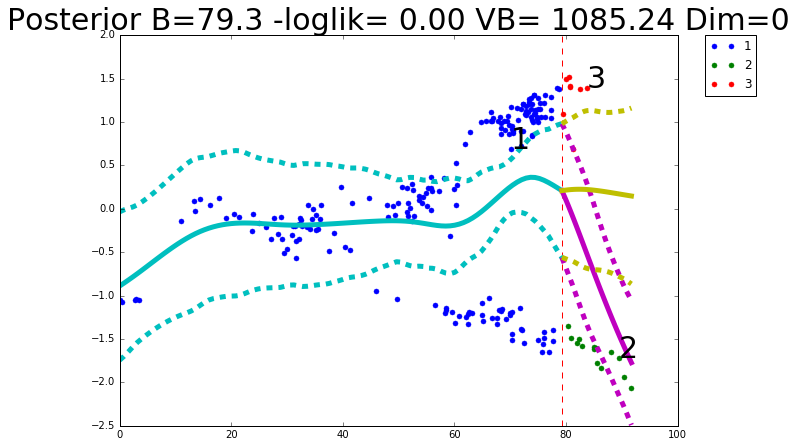

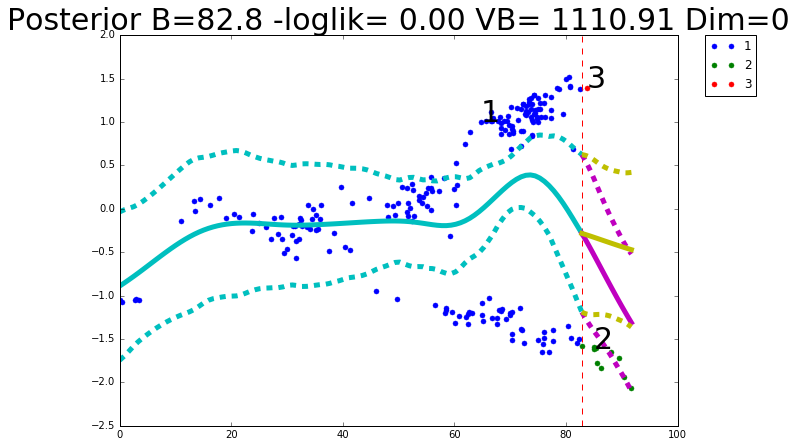

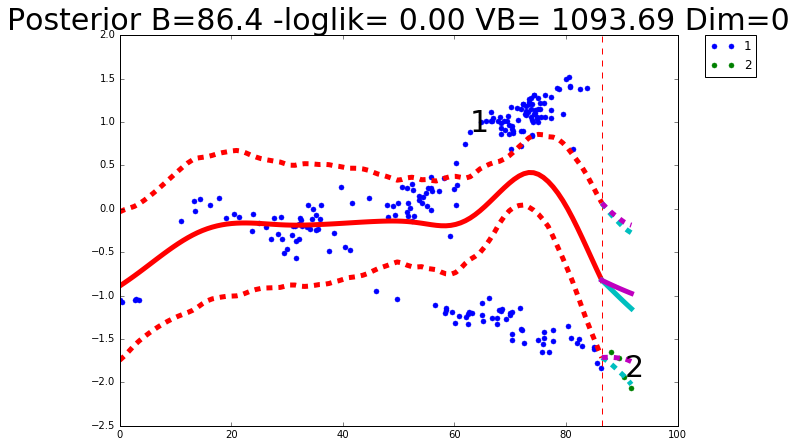

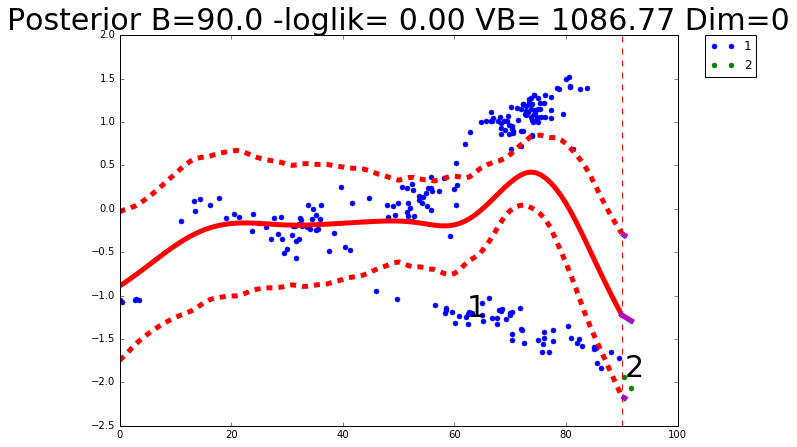

In [8]:
Bpossible = np.linspace(22,90,20)
logVBBound = []

Kbranch = m.kern
pt = mV.t

#mV.kern.branchkernelparam.Bv.fixed = False
#mV._compile()

for ib,b in enumerate(Bpossible):
    Bcrap = np.atleast_2d(b) # crappy branch point

    # reset branching allocations for before branching point
    bestAssignmentCensored = list(bestAssignment)
    for i,bi in enumerate(bestAssignment):
        if mV.X[bi,0] < b :
            # before branching point 
            bestAssignmentCensored[i] = m.indices[i][0]
        
    # Variational bound computation
    mV.kern.branchkernelparam.Bv = Bcrap
    print 'Variational kernel branch value ' + str(mV.kern.branchkernelparam.Bv._array.flatten())
    # Set state for assignments
    
    fSoft = True
    if(fSoft):
        mV.InitialisePhi(m.indices, bestAssignmentCensored, b, condProbs, fSoftAssignment = True, fSoftUni = True)
    else:
        N = Y.shape[0]
        phiInitial = np.zeros((N, 3*N))
        phiInitial_invSoftmax = np.zeros((N, 3*N))  # large neg number makes exact zeros, make smaller for added jitter
        for i, n in enumerate(bestAssignmentCensored):
            phiInitial[i, n] = 1
            phiInitial_invSoftmax[i, n] = 10
        mV.logPhi = phiInitial_invSoftmax

    VBbound = mV._objective(mV.get_free_state())[0] # this is -log of bound
    logVBBound.append(VBbound)

    assigngp_dense.PlotSample(D, mV.X[bestAssignmentCensored, : ],3,Y,Bcrap,lw=5.,fs=30, \
                          mV=mV, figsizeIn=(D*10,D*7), title='Posterior B=%.1f -loglik= %.2f VB= %.2f'%(b,0,VBbound))



    print 'B=' + str(b) + '. VB bound=%.2f.'%(VBbound)    

VB estimated B 43.4736842105 with marginal likelihood [ 642.87578233]


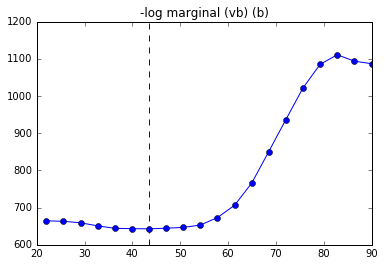

In [9]:
nlogL = np.array(logVBBound)
iMin = np.argmin(nlogL)
plt.plot(Bpossible[:len(logVBBound)],nlogL, '-ob')
plt.title('-log marginal (vb) (b)')

v=plt.axis()
minB = Bpossible[iMin]
plt.plot([minB,minB],v[-2:],'--b')

print 'VB estimated B ' + str(minB) + ' with marginal likelihood ' + str(logVBBound[iMin])